# Assign2: Multiclass Classification




Task: Building a logistic regression model for a sentiment classification task. The dataset used was 36547 reviews on Amazon classified as negative (1 or 2 star) or positive (4 or 5 star).

### Data Preprocessing
The code for reading in, preprocessing, word2vec encoding the data is as follows.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import re
import math
from tqdm import tqdm
import pandas as pd

## Download w2v embeddings
import gensim.downloader as api
w = api.load('word2vec-google-news-300')
vocab=[x for x in w.key_to_index.keys()]


## Data Loading
!wget https://raw.githubusercontent.com/cbannard/lela60331_24-25/refs/heads/main/coursework/Compiled_Reviews.txt

## Create lists
reviews=[]
sentiment_ratings=[]
product_types=[]
helpfulness_ratings=[]

with open("Compiled_Reviews.txt") as f:
  # iterate over the lines in the file
   for line in f.readlines()[1:]:
        # split the current line into a list of two element - the review and the labels
        fields = line.rstrip().split('\t')
        # put the current review in the reviews list
        reviews.append(fields[0])
        # put the current sentiment rating in the sentiment_rating list
        sentiment_ratings.append(fields[1])
        # put the current product types in the product_types list
        product_types.append(fields[2])
        # put the current helpfulness marking in the helpfulness_ratings list
        helpfulness_ratings.append(fields[3])

## Text Processing
import re
# Tokenizes each review using regex to split on whitespace
tokenized_sents = [re.findall("[^ ]+",txt) for txt in reviews]
# Combines all tokens into a single list
tokens=[]
for s in tokenized_sents:
      tokens.extend(s)
# Creates a set of unique tokens (types)
types=set(tokens)

## Word Vector Processing
# Get indices of words that exist in the Word2Vec vocabulary
vocab_dict = {word: idx for idx, word in enumerate(vocab)}
indices = [vocab_dict[x] for x in types if x in vocab_dict]
# Create a list of included types
vocab_set = set(vocab)  # 将vocab转换为集合
types_inc = [x for x in types if x in vocab_set]
# Extract corresponding word vectors from Word2Vec model
M=w[indices]
M.shape


## Generate Review Embeddings
from tqdm import tqdm
types_inc_dict = {word: idx for idx, word in enumerate(tqdm(types_inc, desc="Creating lookup dictionary"))}
embeddings = []
for rev in tqdm(reviews, desc="Generating embeddings"):
    tokens = re.findall("[^ ]+", rev)
    # 使用列表推导获取所有有效token的索引
    token_indices = [types_inc_dict[t] for t in tokens if t in types_inc_dict]
    if token_indices:
      # 使用NumPy的向量化操作一次性计算平均值
        this_vec = np.mean(M[token_indices], axis=0)
    embeddings.append(this_vec)

import pandas as pd
df = pd.DataFrame(np.vstack(embeddings),
                 columns=[f"dim_{i}" for i in range(300)])
df.to_csv("embeddings.csv", index=False)

# convert to a numpy array
embeddings=np.array(embeddings).squeeze()




--2025-01-16 18:23:33--  https://raw.githubusercontent.com/cbannard/lela60331_24-25/refs/heads/main/coursework/Compiled_Reviews.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22322605 (21M) [text/plain]
Saving to: ‘Compiled_Reviews.txt.2’

Compiled_Reviews.tx 100%[===================>]  21.29M   124MB/s    in 0.2s    

2025-01-16 18:23:34 (124 MB/s) - ‘Compiled_Reviews.txt.2’ saved [22322605/22322605]



Generating embeddings: 100%|██████████| 36548/36548 [00:07<00:00, 5125.11it/s]


Generate one-hot encoded input matrices for training, development and test

In [30]:
## split training and test data
import math
import matplotlib.pyplot as plt
import numpy as np

train_ints=np.random.choice(len(embeddings),int(len(embeddings)*0.8),replace=False)
test_ints=list(set(range(0,len(embeddings))) - set(train_ints))
# These are the training embeddings
M_train = np.array(embeddings[train_ints,]).T
# These are the test embeddings
M_test = np.array(embeddings[test_ints,]).T


unique_labels=list(set(helpfulness_ratings))
unique_one_hot=np.diag(np.ones(len(unique_labels)))

labels_train = [helpfulness_ratings[i] for i in train_ints]
labels_test = [helpfulness_ratings[i] for i in test_ints]

y_train=np.array([list(unique_one_hot[k]) for k in [unique_labels.index(x) for x in labels_train]]).T
y_test=np.array([list(unique_one_hot[k]) for k in [unique_labels.index(x) for x in labels_test]]).T


print(M_train.shape)
print(M_test.shape)
print(y_train.shape)
print(y_test.shape)

(300, 29238)
(300, 7310)
(3, 29238)
(3, 7310)


### Fit the Model
Fit logistic regression models using the embedding-based representation of the reviews data. Train on the training data. Calculate precision and recall for the classifier on the test data.

In [31]:
M_train=M_train.T
M_test=M_test.T
y_train=y_train.T
y_test=y_test.T

In [23]:
print(M_train[0:100])

[[ 1.08694458  1.3270874   1.35329437 ... -0.43414307  0.1292572
  -1.23973083]
 [ 0.35089111  0.84226799  0.43411255 ...  0.45263672  0.91194153
   0.09864044]
 [ 2.55715942  6.22270012  4.36815643 ... -2.2517395  11.79866028
  -3.24542618]
 ...
 [ 3.26841736  2.61133957  4.36611938 ... -4.81111145  4.20079041
  -4.17809677]
 [ 1.30886841  2.37915993  0.39526367 ...  0.337677    1.3019104
  -0.4251709 ]
 [ 0.39694214  0.43226433  0.68261719 ...  0.13873291  0.55578613
  -0.13099289]]


In [16]:
print(y_test[999])

[0. 0. 1.]


Text(0, 0.5, 'loss')

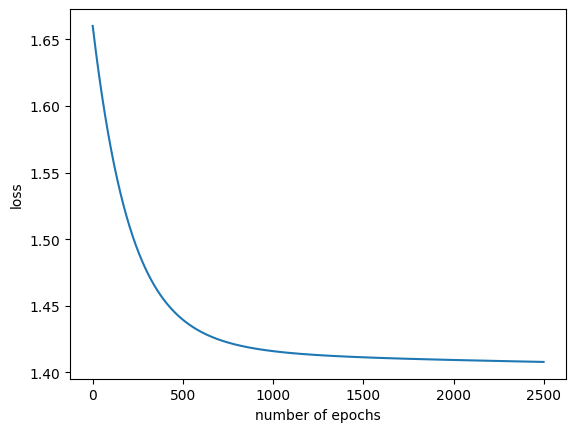

In [34]:
np.random.seed(10)
n_iters = 2500
num_features=300
num_classes=3
num_samples =len(M_train)
weights = np.random.rand(num_features,num_classes)
lr=0.01
logistic_loss=[]
z=np.zeros((num_samples,num_classes))
q=np.zeros((num_samples,num_classes))

for i in range(n_iters):

    z= M_train.dot(weights)
    # print(z)
    z_sum=np.exp(z).sum(axis=1)
    # print(z_sum)
    q=np.array([list(np.exp(z_i)/z_sum[i]) for i, z_i in enumerate(z)])
    # print(q)
    loss=np.mean(-np.log2((np.sum((y_train*q),axis=1))))
    # print(loss)

    logistic_loss.append(loss)

    dw=M_train.T.dot((q-y_train))/num_samples
    weights=(weights - (dw*lr))

plt.plot(range(1,n_iters),logistic_loss[1:])
plt.xlabel("number of epochs")
plt.ylabel("loss")

In [38]:
print(weights.shape)
print(M_test.shape)

(300, 3)
(7310, 300)


In [45]:
z = M_test.dot(weights)
z_sum=np.exp(z).sum(axis=1)
q=np.array([list(np.exp(z_i)/z_sum[i]) for i, z_i in enumerate(z)])
y_test_pred=np.argmax(q,axis=1)
y_test_true=np.argmax(y_test,axis=1)

TP=[]
for j in range(3):
 TP.append(np.sum(np.array([int(s == j and y_test_true[i] == j) for i,s in enumerate(y_test_pred)])))

FP=[]
for j in range(3):
 FP.append(np.sum(np.array([int(s == j and y_test_true[i] != j) for i,s in enumerate(y_test_pred)])))

FN=[]
for j in range(3):
 FN.append(np.sum(np.array([int(s != j and y_test_true[i] == j) for i,s in enumerate(y_test_pred)])))


PRECISION=np.array(TP)/(np.array(TP)+np.array(FP))
RECALL=np.array(TP)/(np.array(TP)+np.array(FN))

PRECISION_MACROAVERAGE=np.mean(PRECISION)
print(PRECISION_MACROAVERAGE)

RECALL_MACROAVERAGE=np.mean(RECALL)
print(RECALL_MACROAVERAGE)


0.36368959024754016
0.33463816355401654
